# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The problem is to use HR data about 1 million job salaries and information about the jobs to predict salary. This prediction can be used to ensure future job offers have a salary that is competitive with the market.

In [76]:
#import libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate, train_test_split
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR 
import time
from scitime import Estimator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from joblib import dump, load



__author__ = "Zachary Yoscovits"
__email__ = "Zachary.yoscovits@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data
train_features = pd.read_csv("data/train_features.csv", index_col = 'jobId')
train_salaries = pd.read_csv("data/train_salaries.csv", index_col = 'jobId')




### ---- 3 Clean the data ----

In [3]:
#Look for Missing Data
train_features.info()
print()
train_salaries.info()
print()
print(train_features.index.is_unique)
print()
print(train_salaries.index.is_unique)



<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, JOB1362684407687 to JOB1362685407686
Data columns (total 7 columns):
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(5)
memory usage: 61.0+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, JOB1362684407687 to JOB1362685407686
Data columns (total 1 columns):
salary    1000000 non-null int64
dtypes: int64(1)
memory usage: 15.3+ MB

True

True


No Null Values in either data set, and no duplicate jobId's in either dataset

In [4]:
categorical_cols = train_features.columns[:5]
for item in categorical_cols:
    print(item, ':', train_features[item].unique())

companyId : ['COMP37' 'COMP19' 'COMP52' 'COMP38' 'COMP7' 'COMP15' 'COMP24' 'COMP20'
 'COMP41' 'COMP56' 'COMP4' 'COMP54' 'COMP57' 'COMP14' 'COMP61' 'COMP58'
 'COMP3' 'COMP44' 'COMP30' 'COMP27' 'COMP34' 'COMP11' 'COMP31' 'COMP49'
 'COMP0' 'COMP1' 'COMP36' 'COMP47' 'COMP8' 'COMP42' 'COMP50' 'COMP53'
 'COMP48' 'COMP45' 'COMP46' 'COMP2' 'COMP5' 'COMP55' 'COMP29' 'COMP40'
 'COMP33' 'COMP22' 'COMP12' 'COMP25' 'COMP6' 'COMP23' 'COMP17' 'COMP28'
 'COMP21' 'COMP26' 'COMP43' 'COMP51' 'COMP10' 'COMP59' 'COMP13' 'COMP39'
 'COMP16' 'COMP9' 'COMP32' 'COMP62' 'COMP35' 'COMP18' 'COMP60']
jobType : ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']
degree : ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']
major : ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']
industry : ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


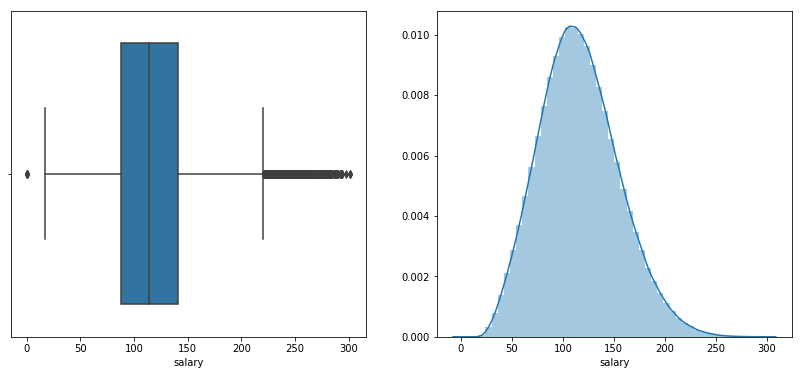

In [5]:
#Take a look at the salary distribution
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_salaries.salary)
plt.subplot(1,2,2)
sns.distplot(train_salaries.salary)
plt.show()

In [6]:
#Merge
train_df = pd.merge(train_features, train_salaries, on='jobId')
train_df.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
#look for outliers using IQR rule
salary_stats = train_df.salary.describe()
IQR = salary_stats['75%'] - salary_stats['25%']
upper_limit = salary_stats['75%'] + 1.5* IQR
lower_limit = salary_stats['25%'] - 1.5* IQR
print('Upper limit is', upper_limit)
print('Lower limit is', lower_limit)


Upper limit is 220.5
Lower limit is 8.5


In [8]:
#look at upper outliers
train_df.jobType[train_df.salary > upper_limit].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

Higher level employees could make this much, but the junior level employees making this much seems suspicious

In [9]:
#Check out the junior level employees
train_df[(train_df.salary > upper_limit) & (train_df.jobType == "JUNIOR")]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226


Many of these have advanced degrees, and they tend to be in Oil and Finance which are lucrative, so these seem to be real

In [10]:
#looking at lower level outliers
train_df[train_df.salary < lower_limit]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


These are all upper level positions and all have a salary of 0; it doesn't make sense that they would be unpaid so I will assume the salary data is missing and remove them from the data set

In [11]:
train_df.drop(train_df.index[train_df.salary < lower_limit], inplace = True)

### ---- 4 Explore the data (EDA) ----

In [12]:
def cat_avg(df, feature, result):
    #calculates the average salary for each category in a categorical column and returns a dataframe with this information
    cat_df = pd.DataFrame()
    cats = df[feature].unique().tolist()
    cat_df['category'] = cats
    means = []
    for cat in cats:
        means.append(train_df[train_df[feature] == cat][result].mean())
    cat_df['mean'] = means
    cat_df.sort_values('mean', inplace = True)
    cat_df.reset_index(drop=True, inplace = True)
    return cat_df

In [13]:
#Take a look at the numerical columns
train_df.describe(include = [np.number])

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [14]:
#take a look at the 
train_df.describe(include = 'O')

,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995
unique,63,8,5,9,7
top,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,16193,125886,236975,532353,143205


In [15]:
def count_plot(df, col):
    #Plots the distribution of a data column
    plt.figure(figsize = (5, 5))
    if df[col].dtype == 'int64':
        sns.distplot(df[col], bins = 5)
    else:
        sns.catplot(x = col, kind = "count",  data = df, order = cat_avg(df, col, "salary")['category'] )
        plt.xticks(rotation=45)
        

    
        


In [16]:
def mean_plot(df, col):
    if df[col].dtype == 'int64':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df, order = cat_avg(df, col, 'salary')['category'])
        plt.xticks(rotation=45)
    

<Figure size 360x360 with 0 Axes>

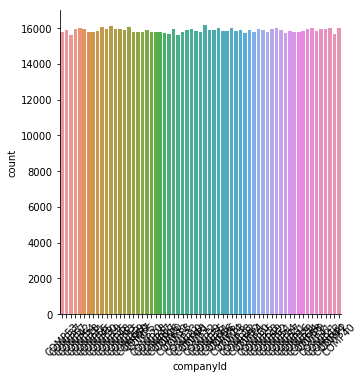

<Figure size 360x360 with 0 Axes>

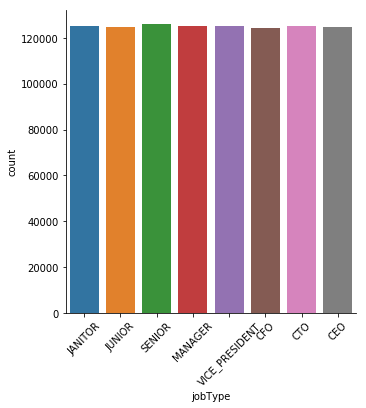

<Figure size 360x360 with 0 Axes>

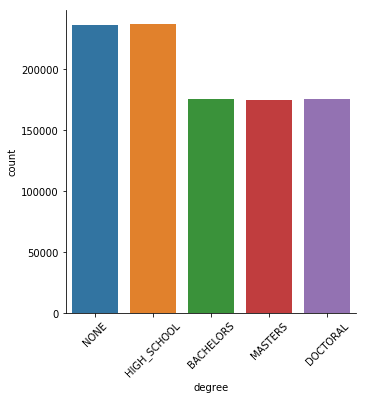

<Figure size 360x360 with 0 Axes>

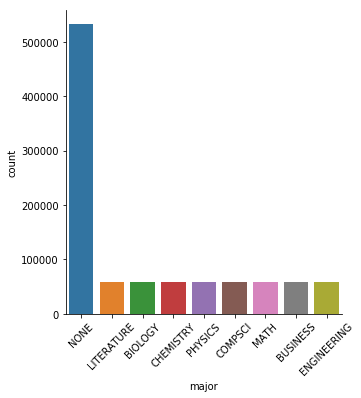

<Figure size 360x360 with 0 Axes>

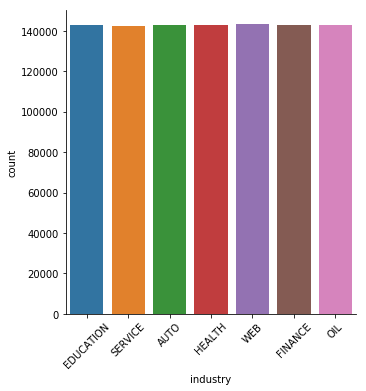

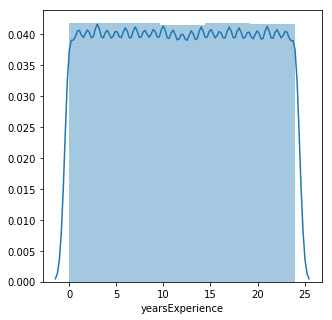

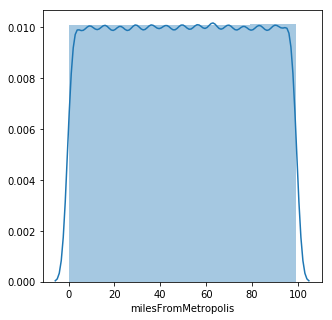

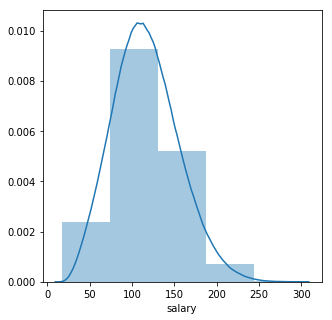

In [17]:
#plot the distribution of all columns
i = 1
for col in train_df.columns:
    count_plot(train_df, col)
    i+= 1
    plt.show()

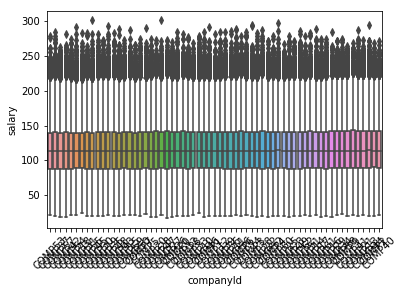

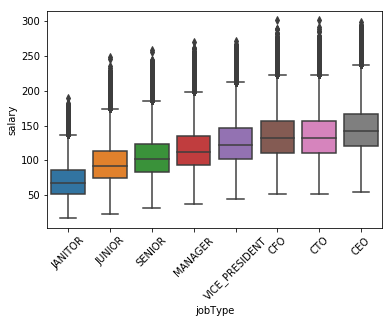

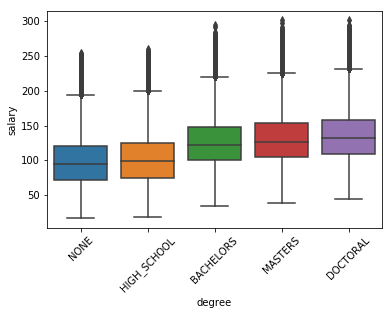

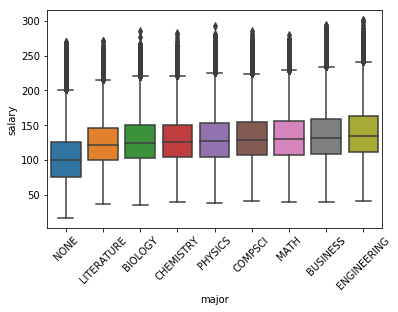

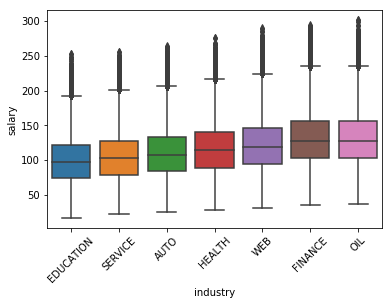

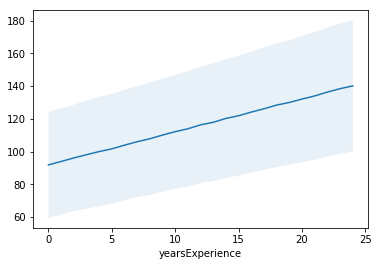

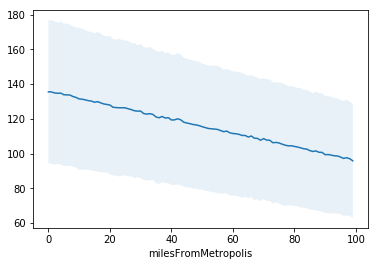

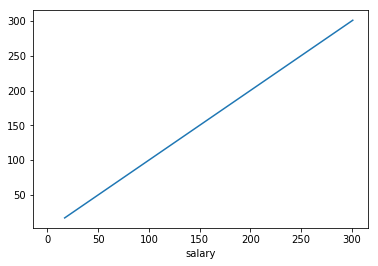

In [18]:
# plot the salary vs the values of each column
i = 1
for col in train_df.columns:
    mean_plot(train_df, col)
    i+= 1
    plt.show()

In [19]:
categoricals = train_features.columns[1:5]
for item in categoricals:
    print(item, ':',  train_features[item].unique())

jobType : ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']
degree : ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']
major : ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']
industry : ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


In [20]:
def avg_dict(df, col, result):
    #creates a dictionary of the average salary for each category in a categorical column
    avg_df = cat_avg(df, col, result)
    avg_dictionary = dict(zip(avg_df['category'],avg_df['mean']))
    return avg_dictionary

In [21]:
def avg_list(df,col, result):
    #takes in a categorical column, and returns a list with each category replaced by its average salary
    avg_dictionary = avg_dict(df, col, result)
    avg_list = []
    for key in df[col]:
        avg_list.append(avg_dictionary[key])
    return avg_list

In [22]:
#create a new collumn for each categorical variable, replacing the categories with average value for that category. 
#This will be used for to calculate create coorrelation heatmap
for col in categorical_cols:
    train_df[(col + '_avg')] = avg_list(train_df,col, "salary")

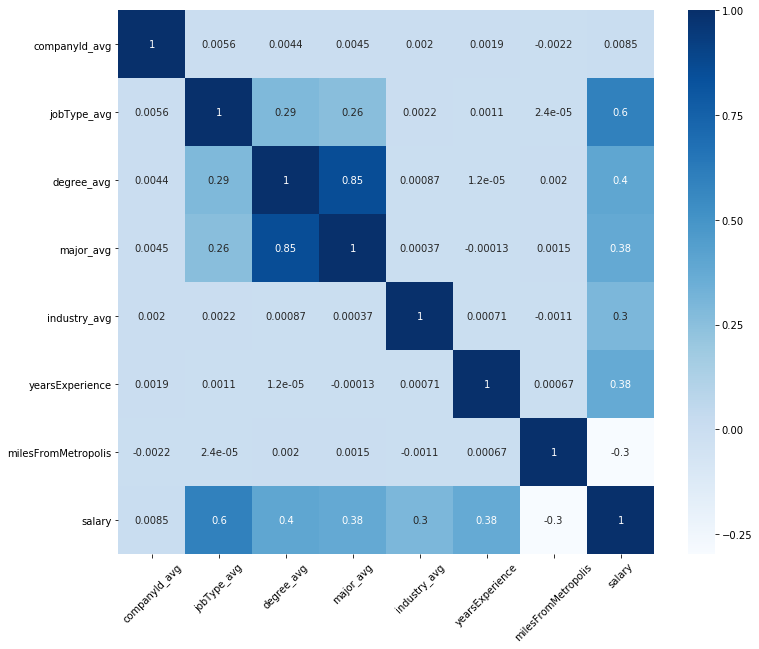

In [23]:
# Create correlation heatmap
fig = plt.figure(figsize=(12, 10))
features = ['companyId_avg', 'jobType_avg', 'degree_avg', 'major_avg', 'industry_avg', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(train_df[features + ['salary']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()

Company ID has no correlation to salary, which is expected from the plots above, so company ID won't be used to predict salary.  This is good, in that models created from this data could be used for predicting salary from other companies.

Major and Degree have a strong  correlation, looking at the plots above, it appears to be entirely caused by "none" major being used for everyone who doesn't have a college degree.  There doesn't seem to be any correlation with salary and major aside from what is already captured in degree level, so we won't use major to make predictions.

All of the other feature variables have vary little correlation with each other, which means each one contains fully independent information.

Miles from Metropolis has a negative correlation with salary, this makes sense since jobs out in the country pay less than jobs in the city.



### ---- 5 Establish a baseline ----

In a business setting one would often have a baseline, as machine learning often involves improving some existing process.  Any changes made from the baseline need to be justified by having better performance  Here I don't have a baseline, so I will create a very basic model to predict salary.  Since job type has the highest correlation with salary, this basic model just predicts the average salary for each job type.

In [24]:
#Making 5 fold training and testing sets to train and test this model.
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5) 
kf_train = { 0 : "kf_train_0", 1 : "kf_train_1", 2 : "kf_train_2", 3 : "kf_train_3", 4 : "kf_train_4"}
kf_test = { 0 : "kf_test_0", 1 : "kf_test_1", 2 : "kf_test_2", 3 : "kf_test_3", 4 : "kf_test_4"}
i=0
for train_index, test_index in kf.split(train_df['jobType']):
    jobtype =list(train_df['jobType'][train_index])
    salary = list(train_df['salary'][train_index])
    kf_train[i] = pd.DataFrame(data = list(zip(jobtype, salary)), columns = ['jobType', 'salary'])
    
    jobtype =list(train_df['jobType'][test_index])
    salary = list(train_df['salary'][test_index])
    kf_test[i] = pd.DataFrame(data = list(zip(jobtype, salary)), columns = ['jobType', 'salary'])
    i +=1
    

    

In [25]:
#Creating predictions from my model
jobType_train = list(np.zeros(5))
for i in range(5):
    
    jobType_train[i] = avg_dict(kf_train[i], 'jobType', 'salary')
    #kf_test[i]['predict'] = jobType_train[i][kf_test[i]['salary']]
    
    predict_list = []
    for j in range(len(kf_test[i]['jobType'])):
        predict_list.append(jobType_train[i][kf_test[i]['jobType'][j]])
    kf_test[i]['predict'] = predict_list
    
   


In [26]:
#Calculating RMSE scores for my model.  RMSE/MSE are the apporpiate metric for regression models.  
#I prefer RMSE because it has the same units as the prediction in this case dollars, and so can be compared to the predictoin itself
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_scores = [sqrt(mean_squared_error(kf_test[i]['salary'],kf_test[i]['predict'])) for i in range(5)]

In [27]:
print(rmse_scores)
print(np.mean(rmse_scores))

[31.099801377339542, 31.06942516048584, 31.137181456230316, 30.955615759449064, 30.973302321251115]
31.047065214951175


### ---- 6 Hypothesize solution ----

I will try to model the data using Random Forest and Gradient Boosting.  for both of these I will use one hot encoding for industry, and ordinal encoding for job type and degree level.  I will also try target mean encoding to encode the average salary for each combination or categorical features.

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [29]:
features = train_df[['jobType', 'degree', 'industry', 'yearsExperience', 'milesFromMetropolis' ]]
salary = train_df['salary']
cats = list(features.select_dtypes(include='object').columns)
print(cats)

['jobType', 'degree', 'industry']


In [30]:
#First we will use one-hot encoding for industry column, as this doesn't have a natural order to it
features['industry2'] = features['industry'].copy()
features = pd.get_dummies(features, columns=['industry2'], prefix = ['industry'])



In [31]:
#Next we will use ordinal mapping to for jobtype and degree, as they both have an order
ordinal_map = {'jobType': {'CFO':5, 'CEO' :6, 'VICE_PRESIDENT':4, 'MANAGER': 3, 'JUNIOR' :1, 'JANITOR': 0, 'CTO' : 5, 'SENIOR' : 2}, 'degree':{'MASTERS' :3, 'HIGH_SCHOOL':1, 'DOCTORAL' :4, 'BACHELORS' :2, 'NONE' :0}}
features.replace(ordinal_map, inplace = True)
features2 = features.copy()
features=features.drop(columns =['industry'])


In [32]:
#Then we will create a transformer to encode the average salary for each combination of categorical features, and use it to create a colum
#that includes this for each job.
class GroupAverage(TransformerMixin,BaseEstimator):

    def __init__(self, categories):
        self.categories = categories

    def fit(self, X, y):
        self.group_averages = dict(pd.concat([X,y], axis = 1).groupby(self.categories)[y.name].mean())
        return self

    def transform(self, X, y='none'):
        X['group_avg'] = pd.DataFrame(X.apply(lambda x: self.group_averages[tuple([x[item] for item in list(self.categories)])], axis = 1))
        X=X.drop(columns = ['industry'])
        return X

### ---- 8 Create models ----

In [ ]:
#create and tune the models

In [ ]:
#Tune Random forest, using a small number of estimators, to speed up run time
rf_lite = RandomForestRegressor(n_estimators=25)
rf_grid = { 'max_depth': [20, 30, 40],
 'max_features': [3,5,'auto'],
 'min_samples_leaf': [1, 10, 20],
 'min_samples_split': [2, 10, 20]}
rf_search=GridSearchCV(estimator = rf_lite, param_grid = rf_grid, scoring='neg_mean_squared_error',n_jobs=-1, cv=2)
rf_search.fit(features,salary)

In [ ]:
print(rf_search.best_params_ )
print(rf_search.best_score_ )


In [ ]:
#Tune gradient boosting, using a small number of estimators, to speed up run time
gb_lite = GradientBoostingRegressor(n_estimators=25)
gb_grid={ 'max_depth': [5,6,7],
 'min_samples_leaf': [1,10, 20],
 'min_samples_split': [2, 10, 20],
  'max_features' : [3,5, 'auto']}
gb_search=GridSearchCV(estimator = gb_lite, param_grid = gb_grid, scoring='neg_mean_squared_error',n_jobs=-1, cv=2)
gb_search.fit(features,salary)


In [ ]:
print(gb_search.best_params_ )
print(gb_search.best_score_ )



In [ ]:
#finer tuning
gb_lite2 = GradientBoostingRegressor(min_samples_leaf = 1, min_samples_split = 2, n_estimators=25)
gb_grid2={ 'max_depth': [8,10,15],
'max_features' : [6,10, 'auto']}
gb_search2=GridSearchCV(estimator = gb_lite2, param_grid = gb_grid2, scoring='neg_mean_squared_error',n_jobs=-1, cv=2)
gb_search2.fit(features,salary)

In [ ]:
print(gb_search2.best_params_ )
print(gb_search2.best_score_ )

In [ ]:
#one more round of tuning
gb_lite3 = GradientBoostingRegressor(min_samples_leaf = 1, min_samples_split = 2, n_estimators=25, max_features = 'auto')
gb_grid3={ 'max_depth': [9,11,12,13,14]}
gb_search3=GridSearchCV(estimator = gb_lite3, param_grid = gb_grid3, scoring='neg_mean_squared_error',n_jobs=-1, cv=2)
gb_search3.fit(features,salary)

In [ ]:
print(gb_search3.best_params_ )
print(gb_search3.best_score_ )

### ---- 9 Test models ----

In [50]:
#do 5-fold cross validation on models and measure MSE and RMSE

In [51]:
# Use best parameters found above to test Random Forest
rf_tuned = RandomForestRegressor(n_estimators=80, max_depth= 20, max_features = 3,min_samples_leaf=20,min_samples_split= 10 )
rf_score = cross_val_score(estimator=rf_tuned, X=features, y=salary, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)

In [53]:
print(rf_score)
print(rf_score.mean())
print(sqrt(-1*rf_score.mean()))

[-385.43876971 -385.08880496 -386.29891184 -382.64657842 -382.84288754]
-384.4631904944053
19.60773292592505


In [54]:
# Use best parameters found above to test gradient boosting
gb_tuned = GradientBoostingRegressor(n_estimators=80, max_depth = 11, min_samples_leaf= 1, min_samples_split= 2, max_features = 'auto')
gb_score = cross_val_score(estimator=gb_tuned, X=features, y=salary, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)

In [66]:
print(gb_score)
print(gb_score.mean())
print(sqrt(-1*gb_score.mean()))

[-385.97589503 -385.55473517 -386.87212579 -383.20106785 -383.71322831]
-385.06341042982086
19.623032651193874


In [58]:
# Use best parameters found above to test Random Forest, with added target means column

ga_rf = Pipeline([('target', GroupAverage(categories = cats)),
                          ('rf', RandomForestRegressor(n_estimators=80, max_depth= 20, max_features = 3,min_samples_leaf=20,min_samples_split= 10 ))])
ga_rf_score = cross_val_score(estimator=ga_rf, X=features2.copy(), y=salary, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)


In [59]:
print(ga_rf_score)
print(ga_rf_score.mean())
print(sqrt(-1*ga_rf_score.mean()))

[-385.44120799 -384.94033384 -386.19245729 -382.4365919  -382.78683827]
-384.3594858587364
19.605088264497468


In [64]:
# Use best parameters found above to test gradient boosting, with added target means column
ga_gb = Pipeline([('target', GroupAverage(categories = cats)),
                          ('gb', GradientBoostingRegressor(n_estimators=80, max_depth = 11, min_samples_leaf= 1, min_samples_split= 2, max_features = 'auto'))])
ga_gb_score = cross_val_score(estimator=ga_gb, X=features2, y=salary, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)


In [65]:
print(ga_gb_score)
print(ga_gb_score.mean())
print(sqrt(-1*ga_gb_score.mean()))

[-385.96639931 -385.0891292  -386.65694506 -382.68075072 -383.73973804]
-384.82659246430677
19.616997539488725


### ---- 10 Select best model  ----

All of the models tested above have near identical RMSE's, so I will use random forest, without target mean, as this runs the fastest

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

Here I will create a single script which loads the data, cleans it and creates features; and then trains the model on the training data, and makes predictions from the test data

In [78]:
#load the data
training_features = pd.read_csv("data/train_features.csv", index_col = 'jobId')
training_salaries = pd.read_csv("data/train_salaries.csv", index_col = 'jobId')
test_features = pd.read_csv("data/test_features.csv", index_col = 'jobId')

#Merge train features and salaries
training_df = pd.merge(training_features, training_salaries, on='jobId')
#Remove zero salary entries from train data
training_df.drop(training_df.index[training_df.salary < lower_limit], inplace = True)
#Encode categories on training data
tr_features = training_df[['jobType', 'degree', 'industry', 'yearsExperience', 'milesFromMetropolis' ]]
tr_salary = training_df['salary']
tr_features = pd.get_dummies(tr_features, columns=['industry'], prefix = ['industry'])
ordinal_map = {'jobType': {'CFO':5, 'CEO' :6, 'VICE_PRESIDENT':4, 'MANAGER': 3, 'JUNIOR' :1, 'JANITOR': 0, 'CTO' : 5, 'SENIOR' : 2}, 'degree':{'MASTERS' :3, 'HIGH_SCHOOL':1, 'DOCTORAL' :4, 'BACHELORS' :2, 'NONE' :0}}
tr_features.replace(ordinal_map, inplace = True)


#encode categories on test data
test_features = test_features[['jobType', 'degree', 'industry', 'yearsExperience', 'milesFromMetropolis' ]]
test_features = pd.get_dummies(test_features, columns=['industry'], prefix = ['industry'])
test_features.replace(ordinal_map, inplace = True)


final_model =RandomForestRegressor(n_estimators=80, max_depth= 20, max_features = 3,min_samples_leaf=20,min_samples_split= 10 )

final_model.fit(tr_features, tr_salary)


dump(final_model, 'SalaryPredictionModel.joblib') 

test_features['prediction'] = final_model.predict(test_features)

                                
                                


### ---- 12 Deploy solution ----

Take a look at the prediction and save it to disk.  Then take a look at the feature importances for the model.

In [79]:
test_features.head()

,jobType,degree,yearsExperience,milesFromMetropolis,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,prediction
jobId,,,,,,,,,,,,
JOB1362685407687,3,1,22,73,0,0,0,1,0,0,0,111.954265
JOB1362685407688,1,0,20,47,1,0,0,0,0,0,0,93.519279
JOB1362685407689,5,3,17,9,0,0,0,1,0,0,0,175.056130
JOB1362685407690,3,1,14,96,0,0,0,0,1,0,0,104.410341
JOB1362685407691,1,4,10,44,0,0,0,0,1,0,0,118.129128


In [80]:
test_features.to_csv(r'data/prediction.csv')

In [82]:
importances = final_model.feature_importances_

In [83]:
feature_importance = pd.DataFrame()
feature_importance['feature']= tr_features.columns
feature_importance['importance'] = importances
feature_importance


,feature,importance
0,jobType,0.379802
1,degree,0.169493
2,yearsExperience,0.196352
3,milesFromMetropolis,0.139144
4,industry_AUTO,0.008123
5,industry_EDUCATION,0.031695
6,industry_FINANCE,0.023644
7,industry_HEALTH,0.004513
8,industry_OIL,0.023408
9,industry_SERVICE,0.016848


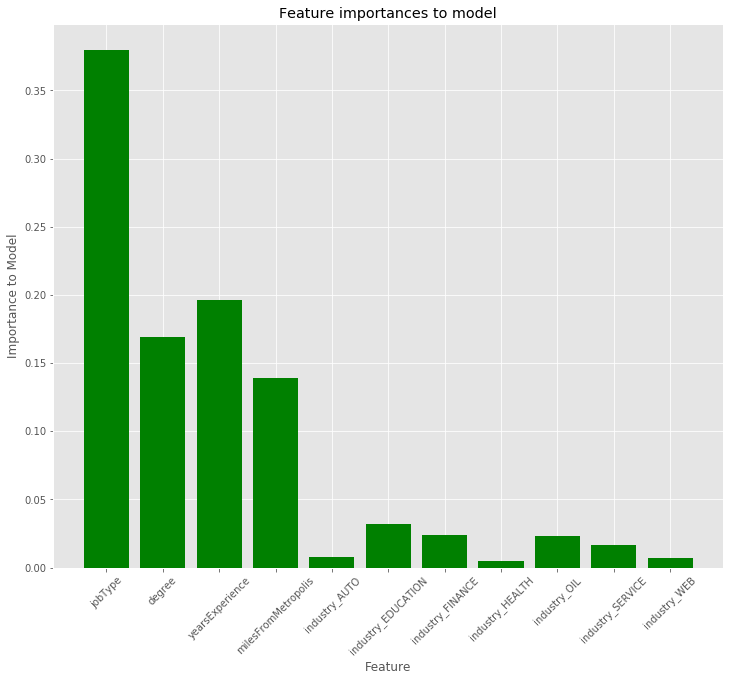

In [86]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 10))
plt.bar(feature_importance['feature'], feature_importance['importance'], color='green')
plt.xlabel("Feature")
plt.ylabel("Importance to Model")
plt.title("Feature importances to model")
plt.xticks(rotation=45)

plt.show()